In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ray

Matplotlib is building the font cache using fc-list. This may take a moment.


In [ ]:
df = pd.read_csv('Data/signal.csv', encoding='utf8', engine='python', sep=',', names=['timestamp', 'value', 'tail'])

df['value'] = df['value'].replace([0], np.NaN).interpolate()

df['timestamp'] = pd.to_datetime(df['timestamp'])

signalData = df['value']

ax = plt.plot(df['value'])
plt.plot((df['tail']*5)+60, color='red')

dataLength = len(df)

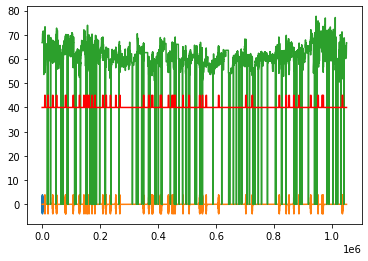

In [21]:
def create_noise_vector(dataLength):
    # Set parameters
    # for anomaly generation

    anomalyLength = 2000
    anomalyAmplitude = 2
    anomalyWavelength = 200 #Data points per period
    anomalyNumber = 50

    # Create single anomaly vector
    singleAnomalyVec = anomalyAmplitude * np.sin(np.array(range(1, anomalyLength))*np.pi / anomalyLength)
    singleAnomalyVec = singleAnomalyVec * 2 * np.sin(np.array(range(1, anomalyLength))*np.pi / anomalyWavelength)

    plt.plot(singleAnomalyVec)

    # Randomly place a number of single vectors onto start dataset

    anomalyStartVec = np.sort(np.floor(np.random.rand(anomalyNumber) * (dataLength - anomalyLength))).astype(int)

    anomalyVec = np.zeros(dataLength)
    anomalyLabel = np.zeros(dataLength)

    for ii in range(anomalyNumber):
        anomalyVec[anomalyStartVec[ii]:anomalyStartVec[ii]+anomalyLength-1] = singleAnomalyVec
        anomalyLabel[anomalyStartVec[ii]:anomalyStartVec[ii]+anomalyLength-1] = 1

    plt.plot(anomalyVec)

    return anomalyVec, anomalyLabel

# Get anomaly vector
anomalyVec, anomalyLabel = create_noise_vector(dataLength)

# Superpose anomaly vector
signalDataAnomaly = signalData + anomalyVec

# Add new outliers
outlierVec = np.random.rand(dataLength)

signalDataAnomaly[outlierVec < 0.0001] = 0

ax = plt.plot(signalDataAnomaly)

plt.plot(anomalyLabel*5+40, color='red')

In [22]:
# Save data
generated_data = pd.DataFrame()
generated_data['timestamp'] = df['timestamp']
generated_data['signalDataAnomaly'] = pd.Series(signalDataAnomaly)
generated_data['anomalyLabel'] = pd.Series(anomalyLabel)

generated_data.to_pickle('generated_data')

In [23]:
 #Load signal
df = pd.read_pickle('generated_data')
dataLength = len(df)
anomalyLength = 2000
anomalyWavelength = 200

In [24]:
# variable "signalDataAnomaly" is the signal to be analysed
# Clean from outliers

df['signalDataAnomaly'].loc[df['signalDataAnomaly'] < 50] = np.NaN
df['signalDataAnomaly'] = df['signalDataAnomaly'].interpolate()

signalDataAnomaly = df['signalDataAnomaly']

# Convert datetime to unix time in [s]
time = (df['timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

anomalyLabel = df['anomalyLabel']

# Perform moving window FFT anomaly detection

winLength = anomalyLength #Length of moving window
winStep = int(round(anomalyLength / 5))

detectionCenterChannel = winLength / anomalyWavelength #Choose center channel of known anomaly frequency

detectionBandWidth = 2 # Half width of detection band (channels)
referenceChannelMin = 100
referenceChannelMax = 200

detectionBandMin = int(detectionCenterChannel - detectionBandWidth)-1
detectionBandMax = int(detectionCenterChannel + detectionBandWidth)-1

jj = 0

anomalyDetectionVec = pd.DataFrame(columns=['1', '2', '3', '4', '5', '6', '7'])

for ii in range(1, dataLength - winLength, winStep):
    winData = signalDataAnomaly[ii:(ii + winLength)]
    winFFT = abs(np.fft.fft(winData))

    anomalyArea = sum(winFFT[detectionBandMin:detectionBandMax]) / (detectionBandMax - detectionBandMin)
    referenceArea = sum(winFFT[referenceChannelMin:referenceChannelMax]) / (referenceChannelMax - referenceChannelMin)

    anomalyDetectionVec.loc[jj, '1'] = anomalyArea / referenceArea

    #Detected anomaly quotient
    anomalyDetectionVec.loc[jj, '2'] = ii

    #Moving window start index
    anomalyDetectionVec.loc[jj, '3'] = ii + winLength

    #Moving window end index
    anomalyDetectionVec.loc[jj, '4'] = np.floor(ii + winLength / 2)

    #Moving window center index
    anomalyDetectionVec.loc[jj, '5'] = time[ii]

    #Moving window start time
    anomalyDetectionVec.loc[jj, '6'] = time[ii + winLength]

    #Moving window end time
    anomalyDetectionVec.loc[jj, '7'] = time[int(np.floor(ii + winLength / 2))]

    #Moving window center time

    '''
    if True: #Set to TRUE for individual FFT plot
        anomalyHitFlag = sum(anomalyLabel[ii:(ii + winLength)]) > 0
        if anomalyHitFlag:
            plt.plot(winFFT(2:100), color='red')
        else:
            plt.plot(winFFT(2:100), color='blue')
        #drawnow
    '''

    jj = jj + 1

print('LOOP FINISHED')

jj = jj-1

LOOP FINISHED


PLOT ANOMALY DET
PLOT ANOMALY LABEL
PLOT ANOMALY AGAIN
PLOT ANOMALU LABEL AGAIN


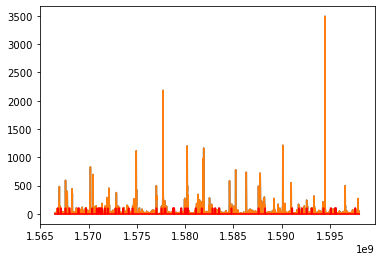

In [25]:
print('PLOT ANOMALY DET')
plt.plot(anomalyDetectionVec['7'], anomalyDetectionVec['1'])

#todo ylim([-1 180])

print('PLOT ANOMALY LABEL')
plt.plot(time,(anomalyLabel*100), color='red')

#todo datetick

print('PLOT ANOMALY AGAIN')
plt.plot(anomalyDetectionVec['7'], anomalyDetectionVec['1'])
#todo ylim([-1 180])

print('PLOT ANOMALU LABEL AGAIN')
plt.plot(time,(anomalyLabel*100), color='red')
#todo datetick

In [26]:
#Calculate anomalyFlag by thresholding

anomalyFlagReference = np.array(anomalyLabel[anomalyDetectionVec['4']]).astype(bool)

truePositive = []
trueNegative = []
falsePositive = []
falseNegative = []
truePositiveRate = []
trueNegativeRate = []

print('START SECOND LOOP')
for ii in range(200):
    anomalyThreshold = ii
    #anomalyFlag = np.zeros(len(anomalyDetectionVec))
    anomalyFlag = np.array(anomalyDetectionVec['1'] > anomalyThreshold)

    #Calculate confusion matrix


    totalSum = len(anomalyFlag)
    truePositive.append(sum(anomalyFlag & anomalyFlagReference))
    trueNegative.append(sum(~anomalyFlag & ~anomalyFlagReference))
    falsePositive.append(sum(anomalyFlag & ~anomalyFlagReference))
    falseNegative.append(sum(~anomalyFlag & anomalyFlagReference))
    truePositiveRate.append(np.array(truePositive).dot(np.linalg.pinv(np.expand_dims(
        np.array(truePositive).astype(int)+np.array(falseNegative).astype(int), axis=0))))

    trueNegativeRate.append(np.array(trueNegative).dot(np.linalg.pinv(np.expand_dims(
        np.array(falsePositive).astype(int)+np.array(trueNegative).astype(int), axis=0))))

START SECOND LOOP


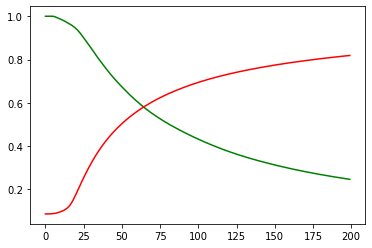

In [17]:
plt.plot(truePositiveRate, color='green')
plt.plot(trueNegativeRate, color='red')

In [18]:
#Choose the threshold value when TRP and TNR crosses
diffTprTnr = abs(np.array(truePositiveRate) - np.array(trueNegativeRate))

anomalyThreshold = np.argmin(diffTprTnr)

anomalyFlag = 1 * (anomalyDetectionVec['1'] > anomalyThreshold)


In [20]:
#Calculate confusion matrix again for the choosen threshold
truePositive_new = (sum(anomalyFlag & anomalyFlagReference))
trueNegative_new = (sum(~anomalyFlag & ~anomalyFlagReference))
falsePositive_new = (sum(anomalyFlag & ~anomalyFlagReference))
falseNegative_new = (sum(~anomalyFlag & anomalyFlagReference))
truePositiveRate_new = (np.array(truePositive).dot(np.linalg.pinv(np.expand_dims(
    np.array(truePositive).astype(int) + np.array(falseNegative).astype(int), axis=0))))

trueNegativeRate_new = (np.array(trueNegative).dot(np.linalg.pinv(np.expand_dims(
    np.array(falsePositive).astype(int) + np.array(trueNegative).astype(int), axis=0))))

confMatrix = [[truePositive_new, falsePositive_new], [falseNegative_new, trueNegative_new]]